# Assignment 3: Transformer-Based NER Models

This notebook fine-tunes and compares two transformer token-classification models for NER on CoNLL-2003:
- `bert-base-cased`
- `microsoft/deberta-v3-base`

Coverage of assignment requirements:
- Model fine-tuning with suitable optimizer/hyperparameters
- Gradient clipping and early stopping
- Entity-level and token-level evaluation
- Confusion matrices for misclassified entities
- Error analysis and trade-off discussion support

## Setup

Install dependencies if needed (uncomment when running in a fresh environment).

In [12]:
!pip -q install transformers torch seqeval scikit-learn matplotlib seaborn pandas numpy tqdm sentencepiece protobuf

## Configuration

**Key toggles for quick testing vs. full training:**

In [13]:
# =======================
# CONFIGURATION TOGGLES
# =======================

# Data: Set to None for full training (14,041 sentences), or specify a number for quick testing
MVP_TRAIN_LIMIT = None  # Uncomment for full dataset

# Training: Epochs to run
NUM_EPOCHS = 5  # Uncomment for full training

# Display configuration
print(f"Configuration:")
print(f"  Training limit: {MVP_TRAIN_LIMIT if MVP_TRAIN_LIMIT else 'Full dataset'}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Recommended for GPU: MVP_TRAIN_LIMIT=None, NUM_EPOCHS=5")
print(f"  Recommended for CPU quick test: MVP_TRAIN_LIMIT=2000, NUM_EPOCHS=2")


Configuration:
  Training limit: Full dataset
  Epochs: 5
  Recommended for GPU: MVP_TRAIN_LIMIT=None, NUM_EPOCHS=5
  Recommended for CPU quick test: MVP_TRAIN_LIMIT=2000, NUM_EPOCHS=2


In [14]:
import torch

if torch.cuda.is_available():
    print("GPU is available and active!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Please ensure your Colab runtime is set to GPU.")

GPU is available and active!
GPU Name: Tesla T4


## Imports and Configuration

In [15]:
import random
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup,
)
from seqeval.metrics import (
    classification_report,
    f1_score as seqeval_f1,
    precision_score as seqeval_precision,
    recall_score as seqeval_recall,
)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report as sk_classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


## Data Loading (CoNLL-2003 from Assignment 2)

In [16]:
def read_conll(path: Path):
    sentences = []
    tokens, pos_tags, labels = [], [], []

    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append((tokens, pos_tags, labels))
                    tokens, pos_tags, labels = [], [], []
                continue

            if line.startswith("-DOCSTART-"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            token, pos, _chunk, ner = parts[0], parts[1], parts[2], parts[3]
            tokens.append(token)
            pos_tags.append(pos)
            labels.append(ner)

    if tokens:
        sentences.append((tokens, pos_tags, labels))

    return sentences


cwd = Path.cwd()
search_paths = [
    cwd / "Assignment2_Name_Entity_Recognition/conll2003",
    cwd / "conll2003",
    cwd.parent / "Assignment2_Name_Entity_Recognition/conll2003",
]

data_dir = next((p for p in search_paths if p.exists()), None)
if data_dir is None:
    raise FileNotFoundError("Could not find CoNLL-2003 folder. Expected Assignment2_Name_Entity_Recognition/conll2003")

train_sents_full = read_conll(data_dir / "eng.train")
val_sents = read_conll(data_dir / "eng.testa")
test_sents = read_conll(data_dir / "eng.testb")

# Use configuration from top cell
train_sents = train_sents_full[:MVP_TRAIN_LIMIT] if MVP_TRAIN_LIMIT else train_sents_full

label_set = sorted({label for _, _, labels in train_sents_full for label in labels})
label2id = {label: idx for idx, label in enumerate(label_set)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Dataset path: {data_dir}")
print(f"Train/Val/Test: {len(train_sents)}/{len(val_sents)}/{len(test_sents)}")
if MVP_TRAIN_LIMIT:
    print(f"  [MVP MODE] Using {MVP_TRAIN_LIMIT}/{len(train_sents_full)} training sentences")
print(f"Labels: {label_set}")

Dataset path: /content/conll2003
Train/Val/Test: 14041/3250/3453
Labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


## Tokenization and Label Alignment

In [17]:
class TokenizedNERDataset(Dataset):
    def __init__(self, sentences, tokenizer, label2id, max_length=256):
        self.samples = []
        self.tokenizer = tokenizer

        for words, _, labels in sentences:
            encoded = tokenizer(
                words,
                truncation=True,
                padding="max_length",
                max_length=max_length,
                is_split_into_words=True,
                return_tensors="pt",
            )

            word_ids = encoded.word_ids()
            aligned_labels = []
            prev_word_id = None

            for word_id in word_ids:
                if word_id is None:
                    aligned_labels.append(-100)
                elif word_id != prev_word_id:
                    aligned_labels.append(label2id[labels[word_id]])
                else:
                    aligned_labels.append(-100)
                prev_word_id = word_id

            self.samples.append(
                {
                    "input_ids": encoded["input_ids"].squeeze(0),
                    "attention_mask": encoded["attention_mask"].squeeze(0),
                    "labels": torch.tensor(aligned_labels, dtype=torch.long),
                }
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def collate_fn(batch):
    return {
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }

## Model Selection

In [18]:
MODEL_CONFIGS = {
    "bert": {
        "hf_name": "bert-base-cased",
        "params_m": 110,
    },
    "deberta": {
        "hf_name": "microsoft/deberta-v3-base",
        "params_m": 86,
    },
}


def load_model_and_tokenizer(model_key):
    cfg = MODEL_CONFIGS[model_key]
    model_name = cfg["hf_name"]

    print(f"Loading {model_key}: {model_name}")
    # DeBERTa-v3 can fail with fast tokenizer conversion in some environments.
    # Force slow tokenizer first; if unavailable, fallback to fast tokenizer.
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
    except Exception as tokenizer_err:
        print(f"  Slow tokenizer load failed: {tokenizer_err}")
        print("  Retrying with fast tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Total params: {total_params:,}")
    return model, tokenizer


bert_model, bert_tokenizer = load_model_and_tokenizer("bert")
deberta_model, deberta_tokenizer = load_model_and_tokenizer("deberta")

Loading bert: bert-base-cased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized beca

  Total params: 107,726,601
Loading deberta: microsoft/deberta-v3-base


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

DebertaV2ForTokenClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; 

  Total params: 183,838,473


## Fine-Tuning Utilities

In [19]:
TRAIN_CFG = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "grad_accum_steps": 2,
    "num_epochs": NUM_EPOCHS,  # Configured in top cell
    "warmup_steps": 500,
    "max_grad_norm": 1.0,
    "early_stopping_patience": 3,
}


def decode_sequences(label_ids, pred_ids, id2label):
    true_str, pred_str = [], []
    for labels, preds in zip(label_ids, pred_ids):
        t_seq, p_seq = [], []
        for l, p in zip(labels, preds):
            if l == -100:
                continue
            t_seq.append(id2label[int(l)])
            p_seq.append(id2label[int(p)])
        if t_seq:
            true_str.append(t_seq)
            pred_str.append(p_seq)
    return true_str, pred_str


def run_eval(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_label_ids, all_pred_ids = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

            preds = outputs.logits.argmax(dim=-1).cpu().numpy()
            label_ids = labels.cpu().numpy()
            all_pred_ids.extend(preds)
            all_label_ids.extend(label_ids)

    avg_loss = total_loss / max(len(dataloader), 1)
    return all_label_ids, all_pred_ids, avg_loss


def compute_metrics(true_seq, pred_seq):
    entity_precision = seqeval_precision(true_seq, pred_seq)
    entity_recall = seqeval_recall(true_seq, pred_seq)
    entity_f1 = seqeval_f1(true_seq, pred_seq)

    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]
    token_precision, token_recall, token_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )

    return {
        "entity_precision": entity_precision,
        "entity_recall": entity_recall,
        "entity_f1": entity_f1,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }


def fine_tune_model(model, tokenizer, model_name, train_sents, val_sents):
    train_ds = TokenizedNERDataset(train_sents, tokenizer, label2id)
    val_ds = TokenizedNERDataset(val_sents, tokenizer, label2id)

    train_loader = DataLoader(train_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

    optimizer = AdamW(model.parameters(), lr=TRAIN_CFG["learning_rate"])
    total_update_steps = (len(train_loader) * TRAIN_CFG["num_epochs"]) // TRAIN_CFG["grad_accum_steps"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=TRAIN_CFG["warmup_steps"],
        num_training_steps=max(total_update_steps, 1),
    )

    best_f1 = -1.0
    patience = 0
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    ckpt_path = Path(f"{model_name}_best.pt")

    for epoch in range(TRAIN_CFG["num_epochs"]):
        model.train()
        optimizer.zero_grad()

        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(train_loader, desc=f"{model_name} epoch {epoch+1}")):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / TRAIN_CFG["grad_accum_steps"]
            loss.backward()
            epoch_loss += loss.item()

            if (step + 1) % TRAIN_CFG["grad_accum_steps"] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CFG["max_grad_norm"])
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

        train_loss = epoch_loss / max(len(train_loader), 1)
        history["train_loss"].append(train_loss)

        val_label_ids, val_pred_ids, val_loss = run_eval(model, val_loader)
        val_true, val_pred = decode_sequences(val_label_ids, val_pred_ids, id2label)
        val_entity_f1 = seqeval_f1(val_true, val_pred) if val_true else 0.0

        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_entity_f1)

        print(f"[{model_name}] epoch={epoch+1} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_entity_f1:.4f}")

        if val_entity_f1 > best_f1:
            best_f1 = val_entity_f1
            patience = 0
            torch.save(model.state_dict(), ckpt_path)
            print(f"  Saved best checkpoint -> {ckpt_path}")
        else:
            patience += 1
            if patience >= TRAIN_CFG["early_stopping_patience"]:
                print(f"  Early stopping triggered (patience={TRAIN_CFG['early_stopping_patience']})")
                break

    if ckpt_path.exists():
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))

    return model, history

## Fine-Tune Models

In [20]:
bert_model, bert_history = fine_tune_model(bert_model, bert_tokenizer, "bert", train_sents, val_sents)
deberta_model, deberta_history = fine_tune_model(deberta_model, deberta_tokenizer, "deberta", train_sents, val_sents)

bert epoch 1:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[bert] epoch=1 train_loss=0.2567 val_loss=0.0567 val_f1=0.9030
  Saved best checkpoint -> bert_best.pt


bert epoch 2:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[bert] epoch=2 train_loss=0.0225 val_loss=0.0376 val_f1=0.9400
  Saved best checkpoint -> bert_best.pt


bert epoch 3:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[bert] epoch=3 train_loss=0.0110 val_loss=0.0375 val_f1=0.9451
  Saved best checkpoint -> bert_best.pt


bert epoch 4:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[bert] epoch=4 train_loss=0.0066 val_loss=0.0385 val_f1=0.9457
  Saved best checkpoint -> bert_best.pt


bert epoch 5:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[bert] epoch=5 train_loss=0.0046 val_loss=0.0397 val_f1=0.9463
  Saved best checkpoint -> bert_best.pt


deberta epoch 1:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[deberta] epoch=1 train_loss=nan val_loss=nan val_f1=0.0559
  Saved best checkpoint -> deberta_best.pt


deberta epoch 2:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[deberta] epoch=2 train_loss=nan val_loss=nan val_f1=0.0559


deberta epoch 3:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[deberta] epoch=3 train_loss=nan val_loss=nan val_f1=0.0559


deberta epoch 4:   0%|          | 0/878 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/204 [00:00<?, ?it/s]

[deberta] epoch=4 train_loss=nan val_loss=nan val_f1=0.0559
  Early stopping triggered (patience=3)


## Test Evaluation (Entity-Level and Token-Level)

In [21]:
def evaluate_on_test(model, tokenizer, model_name, test_sents):
    test_ds = TokenizedNERDataset(test_sents, tokenizer, label2id)
    test_loader = DataLoader(test_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

    start = time.time()
    test_label_ids, test_pred_ids, test_loss = run_eval(model, test_loader)
    infer_time = time.time() - start

    true_seq, pred_seq = decode_sequences(test_label_ids, test_pred_ids, id2label)
    metrics = compute_metrics(true_seq, pred_seq)

    print(f"\n{model_name.upper()} - Entity-level")
    print(classification_report(true_seq, pred_seq, digits=4))

    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]
    print(f"{model_name.upper()} - Token-level")
    print(sk_classification_report(y_true, y_pred, digits=4, zero_division=0))

    print(
        f"{model_name.upper()} summary: "
        f"entity_f1={metrics['entity_f1']:.4f}, token_f1={metrics['token_f1']:.4f}, "
        f"inference_time={infer_time:.2f}s"
    )

    metrics.update({
        "test_loss": test_loss,
        "inference_time": infer_time,
        "true_seq": true_seq,
        "pred_seq": pred_seq,
    })
    return metrics


bert_results = evaluate_on_test(bert_model, bert_tokenizer, "bert", test_sents)
deberta_results = evaluate_on_test(deberta_model, deberta_tokenizer, "deberta", test_sents)

Evaluating:   0%|          | 0/216 [00:00<?, ?it/s]


BERT - Entity-level
              precision    recall  f1-score   support

         LOC     0.9395    0.9311    0.9353      1668
        MISC     0.7764    0.8262    0.8006       702
         ORG     0.8707    0.9079    0.8889      1661
         PER     0.9633    0.9573    0.9603      1617

   micro avg     0.9042    0.9187    0.9114      5648
   macro avg     0.8875    0.9056    0.8962      5648
weighted avg     0.9058    0.9187    0.9120      5648

BERT - Token-level
              precision    recall  f1-score   support

       B-LOC     0.9471    0.9335    0.9402      1668
      B-MISC     0.8271    0.8519    0.8393       702
       B-ORG     0.8915    0.9205    0.9058      1661
       B-PER     0.9664    0.9592    0.9628      1617
       I-LOC     0.8782    0.9261    0.9015       257
      I-MISC     0.6371    0.7639    0.6947       216
       I-ORG     0.8909    0.9293    0.9097       835
       I-PER     0.9854    0.9896    0.9875      1156
           O     0.9967    0.9931    0

Evaluating:   0%|          | 0/216 [00:00<?, ?it/s]


DEBERTA - Entity-level


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LOC     0.0309    0.8609    0.0597      1668
        MISC     0.0000    0.0000    0.0000       702
         ORG     0.0000    0.0000    0.0000      1661
         PER     0.0000    0.0000    0.0000      1617

   micro avg     0.0309    0.2542    0.0551      5648
   macro avg     0.0077    0.2152    0.0149      5648
weighted avg     0.0091    0.2542    0.0176      5648

DEBERTA - Token-level
              precision    recall  f1-score   support

       B-LOC     0.0359    1.0000    0.0694      1668
      B-MISC     0.0000    0.0000    0.0000       702
       B-ORG     0.0000    0.0000    0.0000      1661
       B-PER     0.0000    0.0000    0.0000      1617
       I-LOC     0.0000    0.0000    0.0000       257
      I-MISC     0.0000    0.0000    0.0000       216
       I-ORG     0.0000    0.0000    0.0000       835
       I-PER     0.0000    0.0000    0.0000      1156
           O     0.0000    0.0000    0.0000     38323

 

## Confusion Matrices (Token-Level BIO Labels)

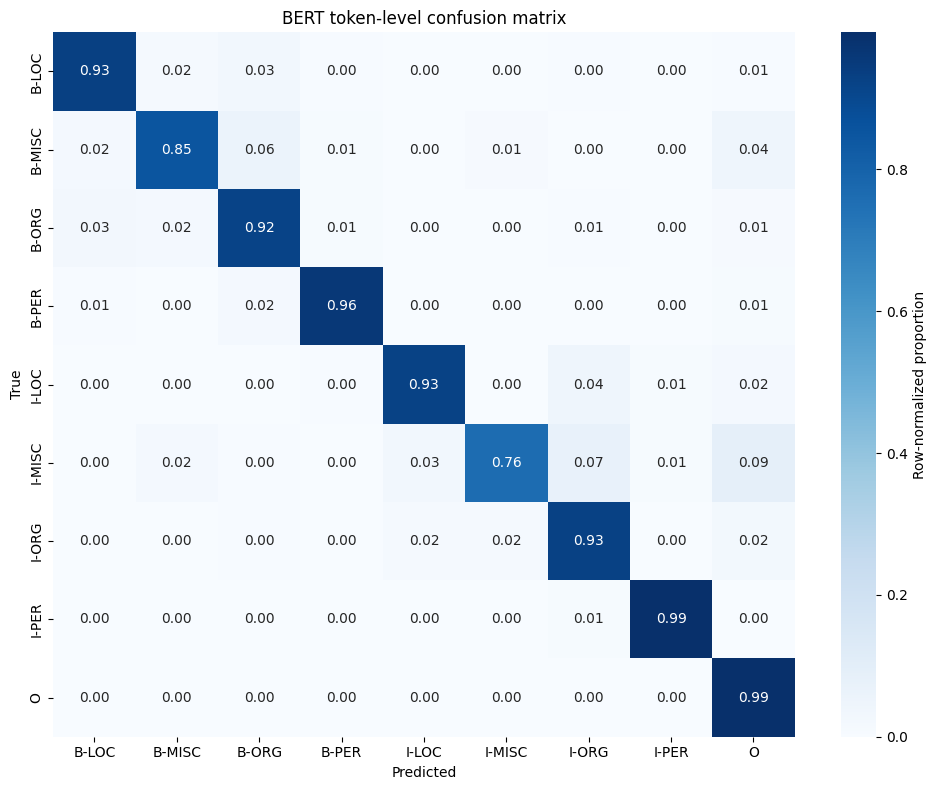

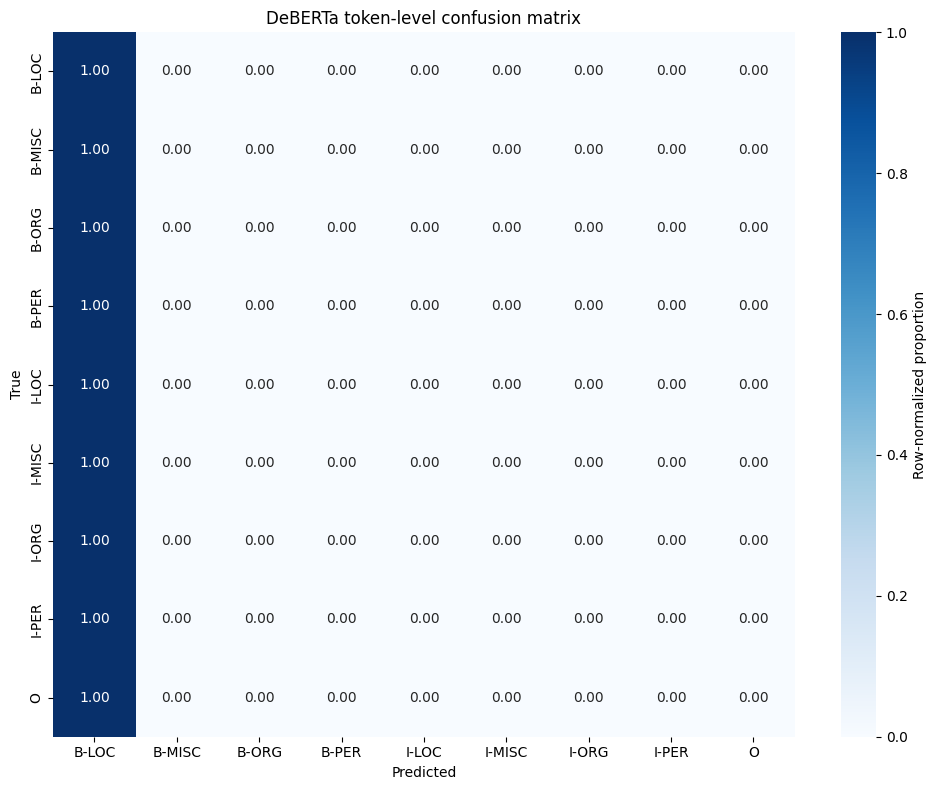

In [22]:
def plot_confusion_mtx(true_seq, pred_seq, model_name):
    labels = sorted(label2id.keys())
    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"label": "Row-normalized proportion"},
    )
    plt.title(f"{model_name} token-level confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


plot_confusion_mtx(bert_results["true_seq"], bert_results["pred_seq"], "BERT")
plot_confusion_mtx(deberta_results["true_seq"], deberta_results["pred_seq"], "DeBERTa")

## Misclassification Analysis

In [23]:
def top_misclassifications(true_seq, pred_seq, top_k=10):
    counts = {}
    for t_seq, p_seq in zip(true_seq, pred_seq):
        for t, p in zip(t_seq, p_seq):
            if t != p:
                counts[(t, p)] = counts.get((t, p), 0) + 1

    rows = [
        {"true_label": t, "pred_label": p, "count": c}
        for (t, p), c in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
    ]
    return pd.DataFrame(rows)


print("BERT top misclassifications")
display(top_misclassifications(bert_results["true_seq"], bert_results["pred_seq"]))

print("DeBERTa top misclassifications")
display(top_misclassifications(deberta_results["true_seq"], deberta_results["pred_seq"]))

BERT top misclassifications


,true_label,pred_label,count
0,O,I-MISC,69
1,O,B-ORG,56
2,O,B-MISC,54
3,B-LOC,B-ORG,52
4,B-ORG,B-LOC,48
5,B-MISC,B-ORG,41
6,O,I-ORG,41
7,B-ORG,B-MISC,34
8,B-PER,B-ORG,32
9,B-MISC,O,31


DeBERTa top misclassifications


,true_label,pred_label,count
0,O,B-LOC,38323
1,B-ORG,B-LOC,1661
2,B-PER,B-LOC,1617
3,I-PER,B-LOC,1156
4,I-ORG,B-LOC,835
5,B-MISC,B-LOC,702
6,I-LOC,B-LOC,257
7,I-MISC,B-LOC,216


## Model Comparison and Trade-Offs

In [24]:
comparison_df = pd.DataFrame([
    {
        "model": "BERT",
        "entity_precision": bert_results["entity_precision"],
        "entity_recall": bert_results["entity_recall"],
        "entity_f1": bert_results["entity_f1"],
        "token_f1": bert_results["token_f1"],
        "inference_time_s": bert_results["inference_time"],
        "params_m": MODEL_CONFIGS["bert"]["params_m"],
    },
    {
        "model": "DeBERTa-v3-base",
        "entity_precision": deberta_results["entity_precision"],
        "entity_recall": deberta_results["entity_recall"],
        "entity_f1": deberta_results["entity_f1"],
        "token_f1": deberta_results["token_f1"],
        "inference_time_s": deberta_results["inference_time"],
        "params_m": MODEL_CONFIGS["deberta"]["params_m"],
    },
])

comparison_df = comparison_df.sort_values("entity_f1", ascending=False).reset_index(drop=True)
display(comparison_df)

winner = comparison_df.iloc[0]
print(f"Best entity-level F1: {winner['model']} ({winner['entity_f1']:.4f})")

,model,entity_precision,entity_recall,entity_f1,token_f1,inference_time_s,params_m
0,BERT,0.904164,0.918732,0.911390,0.982406,52.254787,110
1,DeBERTa-v3-base,0.030925,0.254249,0.055143,0.035921,19.811388,86


Best entity-level F1: BERT (0.9114)


## Training Curves

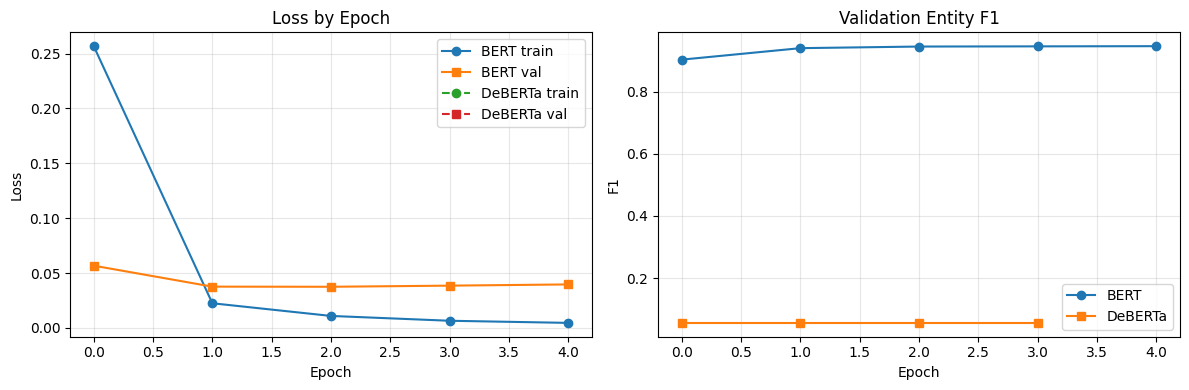

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(bert_history["train_loss"], marker="o", label="BERT train")
plt.plot(bert_history["val_loss"], marker="s", label="BERT val")
plt.plot(deberta_history["train_loss"], marker="o", linestyle="--", label="DeBERTa train")
plt.plot(deberta_history["val_loss"], marker="s", linestyle="--", label="DeBERTa val")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(bert_history["val_f1"], marker="o", label="BERT")
plt.plot(deberta_history["val_f1"], marker="s", label="DeBERTa")
plt.title("Validation Entity F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Requirement Checklist

- Two transformer models for token classification: `bert-base-cased`, `deberta-v3-base`
- Fine-tuning with `AdamW`, LR/batch-size configuration, gradient clipping, early stopping
- Metrics: Precision/Recall/F1 at both entity-level and token-level
- Confusion matrix for misclassified entities (token-level BIO labels)
- Misclassification pattern extraction with top confusion pairs
- Accuracy vs speed vs parameter-count comparison for discussion
